In [3]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import numpy as np
from time import time

CUDA = torch.cuda.is_available()

### Load Data

In [4]:
RAW_DATA_DIR = "../Data/Raw/"
PROCESSED_DATA_DIR = "../Data/Processed/VAE/Z2/"

class CovariateDataset(Dataset):
    def __init__(self, file_name_pattern, file_name_args):
        self.file_name = file_name_pattern.format(*file_name_args, "covar")
        self.assignment_file_name = file_name_pattern.format(*file_name_args, "assignment")
        
        self.data = np.loadtxt(RAW_DATA_DIR + self.file_name + ".csv", delimiter=",")[:, 1:] # remove bias
        self.assignment_data = np.loadtxt(RAW_DATA_DIR + self.assignment_file_name + ".csv", delimiter=",")
        
    def __getitem__(self, index):
        return (self.data[index].astype(float), 0)

    def __len__(self):
        return self.data.shape[0]
    
    def save_processed_data(self, data):
        name = PROCESSED_DATA_DIR + self.file_name+".csv"
        np.savetxt(name, data, delimiter=",")

### Define Model

The code below defines a Variation Autoencoder. The a full, statistically-ground explanation of this design is provided in Section 4 of the paper. The code below is loosely based on example code from the PyTorch library found here: https://github.com/pytorch/examples/blob/master/vae/main.py. This example was extended to allow for both normal and binomial distributions on different dimensions in the output space. The decision to use 3 hidden layers of size 128, 64 and 32 in both the encoder and decoder was larger made through experimentation. Unlike in the Autoencoder, deeper networks here allow fuller representation of the complex functions required to parameterize the $P(X|Z)$ and $Q(Z|X)$ distributions. 

In [5]:


SEED = 1

ZDIMS = 2 # latent dimensions

# Hidden layers
INTERMEDIATE_DIMS = 128
INTERMEDIATE_DIMS_2 = 64
INTERMEDIATE_DIMS_3 = 32
FEATURES = 10
DIAG_VAR = True

BINARY = [0, 2, 5, 7, 8]
NORMAL = [1, 3, 5, 6, 9]

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

class ModifiedVAE(nn.Module):
    def __init__(self):
        super(ModifiedVAE, self).__init__()
        
        self.relu = nn.ReLU()
        
        # ENCODER LAYERS
        self.dense1 = nn.Linear(FEATURES, INTERMEDIATE_DIMS)
        self.dense1_2 = nn.Linear(INTERMEDIATE_DIMS, INTERMEDIATE_DIMS_2)
        self.dense1_3 = nn.Linear(INTERMEDIATE_DIMS_2, INTERMEDIATE_DIMS_3)
        
        self.dense2_1 = nn.Linear(INTERMEDIATE_DIMS_3, ZDIMS)  # mu layer
        self.dense2_2 = nn.Linear(INTERMEDIATE_DIMS_3, ZDIMS)  # logvariance layer
        
        # this last layer bottlenecks through ZDIMS connections

        # DECODER LAYERS
        self.dense3 = nn.Linear(ZDIMS, INTERMEDIATE_DIMS_3)
        self.dense3_2 = nn.Linear(INTERMEDIATE_DIMS_3, INTERMEDIATE_DIMS_2)
        self.dense3_3 = nn.Linear(INTERMEDIATE_DIMS_2, INTERMEDIATE_DIMS)
        
        self.dense4 = nn.Linear(INTERMEDIATE_DIMS, len(BINARY))
        self.dense5 = nn.Linear(INTERMEDIATE_DIMS, len(NORMAL))
        
        self.sigmoid = nn.Sigmoid()
    
    # This function transforms input into 
    # the parameters for the $Q(Z|X)$ distribution. 
    # These correspond to v and $\Sigma$ in Section 4. 
    # Sigma is represented in log form to improve numerical stability. 
    def encode(self, x):
        h1 = self.relu(self.dense1(x))
        h2 = self.relu(self.dense1_2(h1))
        h3 = self.relu(self.dense1_3(h2))
        
        return self.dense2_1(h3), self.dense2_2(h3) #mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            # If we sampled directly from the latent distribution
            # we wouldn't be able to backprop the results because
            # there is no clear grad on the distribution

            # This reparam samples from a unit gaussian and then scales
            # by the latent parameters giving a defined route to backprop.

            std = logvar.mul(0.5).exp_() 

            # Sample from a unit gaussian with dimensions matching
            # the latent space.
            eps = Variable(std.data.new(std.size()).normal_())

            return eps.mul(std).add_(mu) # rescale and return
        else:
            print("no sample")
            return mu
    
    # This code transforms an input in latent space
    # into an output in the observed space. A sigmoid
    # activation is applied to the binomial covariates
    # to create soft conformance to 0/1 while no activation 
    # is applied to those assumed to be normal.
    def decode(self, z):
        h4 = self.relu(self.dense3(z))
        h5 = self.relu(self.dense3_2(h4))
        h6 = self.relu(self.dense3_3(h5))
        
        binary_mu_out = self.sigmoid(self.dense4(h6))
        normal_mu_out = self.dense5(h6)
        
        return binary_mu_out, normal_mu_out
    
    # This peforms a complete forward pass through the network.
    def forward(self, x):
        latent_mu, latent_logvar = self.encode(x.view(-1, FEATURES))
        z = self.reparameterize(latent_mu, latent_logvar)
        binary_mu_out, normal_mu_out = self.decode(z)
        return binary_mu_out, normal_mu_out, latent_mu, latent_logvar

# An implementation of the negative ELBO as described in the paper. 
# Note that cross entropy is used for the binary variables and MSE
# for the normal variables. 
def loss_function(recon_binary_mu, recon_normal_mu, batch_x, mu_latent, logvar_latent):
    
    # MSE: how good is the reconstruction in terms of
    mse_loss = nn.MSELoss(size_average=False)
    normal_recon_loss = mse_loss(recon_normal_mu, batch_x[:, NORMAL])
    normal_recon_loss /= (batch_x.size()[0])
    
    # Cross Entropy:
    BCE = F.binary_cross_entropy(recon_binary_mu, batch_x[:, BINARY], size_average=False)
    BCE /= (batch_x.size()[0])
    
    # KLD is Kullback–Leibler divergence. Regularize VAE by
    # penalizing divergence from the prior

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = -0.5 * torch.sum(1 + logvar_latent - mu_latent.pow(2) - logvar_latent.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= batch_x.size()[0] * FEATURES

### DEBUG
#     print("RL", normal_recon_loss.data.cpu().numpy()[0])
#     print("BCE", BCE.data.cpu().numpy()[0])
#     print("KLD", KLD.data.cpu().numpy()[0])
    
    return normal_recon_loss + BCE + KLD

def train(model, optimizer, epoch, data_loader, log_results=False):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(data_loader):
        data = Variable(data)
        data = data.float()
        if CUDA:
            data = data.cuda()
        
        optimizer.zero_grad()

        binary_mu_out, normal_mu_out, mu_latent, logvar_latent = model(data)
        
        # calculate loss
        loss = loss_function(binary_mu_out, normal_mu_out, data, mu_latent, logvar_latent)
        train_loss += loss.data[0]
        
        # Find the gradient and descend
        loss.backward()
        optimizer.step()
        
    if log_results:
        print('====> Epoch: {} Average loss: {:.8f}'.format(
              epoch, train_loss / len(data_loader.dataset)))

In [7]:
print(ModifiedVAE())

ModifiedVAE(
  (relu): ReLU()
  (dense1): Linear(in_features=10, out_features=128, bias=True)
  (dense1_2): Linear(in_features=128, out_features=64, bias=True)
  (dense1_3): Linear(in_features=64, out_features=32, bias=True)
  (dense2_1): Linear(in_features=32, out_features=2, bias=True)
  (dense2_2): Linear(in_features=32, out_features=2, bias=True)
  (dense3): Linear(in_features=2, out_features=32, bias=True)
  (dense3_2): Linear(in_features=32, out_features=64, bias=True)
  (dense3_3): Linear(in_features=64, out_features=128, bias=True)
  (dense4): Linear(in_features=128, out_features=5, bias=True)
  (dense5): Linear(in_features=128, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)


### Define Training

The procedure used here and all of the hyperparameters involved were discussed in the Autoencoder section above. The initial learning rate and the annealing schedule were adjusted by experimentation. 

In [18]:
def train_model(model_class, dataset, dataset_number, verbose=True):
    model = model_class()
    if CUDA:
        model = model.cuda()

    num_epochs = 3000
    batch_size = 1000
    learning_rate = 1e-2
    lr_sched = False
         
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [int(num_epochs/4), int(3*num_epochs/4)], gamma=0.1)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(1, num_epochs+1):
        checkpoint_interval = int(num_epochs/10)
        
        if lr_sched:
            scheduler.step()

        log = False
        if epoch%checkpoint_interval == 0:
            log = True
            
        train(model, optimizer, epoch, data_loader, log_results=log)
    

    torch.save(model.state_dict(), "../Models/VAE_{}.pth".format(dataset_number))
    
    # Show reconstruction
    model.eval()
    print("Training state: ", model.training)
    
    original_data,_ = next(iter(data_loader))
    original_data = Variable(original_data)
    original_data = original_data.float()
    if CUDA:
        original_data = original_data.cuda()
        
    binary_mu_out, normal_mu_out, mu_latent, logvar_latent = model(original_data)
    
    return model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent

def encode_data(model, dataset):
    all_data = torch.from_numpy(dataset.data)
    all_data = Variable(all_data)
    all_data = all_data.float()
    
    if CUDA:
        all_data = all_data.cuda()
    
    model.eval()
    latent_mu, latent_var = model.encode(all_data)
    
    if CUDA:
        latent_mu = latent_mu.cpu()
        latent_var = latent_var.cpu()
        
    data = np.hstack([latent_mu.data.numpy(), latent_var.data.numpy()])
    dataset.save_processed_data(data)

In [15]:
dataset = CovariateDataset("n_{}_model_{}_v_{}_{}_data", [1000, "A_add_lin", 0])
trained_model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent = \
    train_model(ModifiedVAE, dataset, 1,verbose=True)

encode_data(trained_model, dataset)

====> Epoch: 1000 Average loss: 0.00277041
====> Epoch: 2000 Average loss: 0.00207642
====> Epoch: 3000 Average loss: 0.00367876
====> Epoch: 4000 Average loss: 0.00173663
====> Epoch: 5000 Average loss: 0.00233836
====> Epoch: 6000 Average loss: 0.00162026
====> Epoch: 7000 Average loss: 0.00157601
====> Epoch: 8000 Average loss: 0.00175528
====> Epoch: 9000 Average loss: 0.00206262
====> Epoch: 10000 Average loss: 0.00158404
Training state:  False
no sample


### Explore Reconstructions

The reconstructions below look pretty accurate to the naked eye. We observe very little distinction in the latent space between treatment and control observations. This is to be expected given the nature of the data generation process used in the Monte Carlo simulations. 

In [137]:
mu_out = torch.Tensor(1000, 10)

for index in BINARY:
    mu_out[:, index] = binary_mu_out[:, BINARY.index(index)].data.cpu()
    
for index in NORMAL:
    mu_out[:, index] = normal_mu_out[:, NORMAL.index(index)].data.cpu()
    
for i in np.random.choice(list(range(1000)), size=5, ):
    print("Orginal:", list(np.round(original_data[i].data.cpu().numpy(), 2)))
    print("Mu out:", list(np.round(mu_out[i].numpy(), 2)))
    print("Mu Latent:", list(np.round(mu_latent[i].data.cpu().numpy(), 2)))
    print("Std latent:", list(np.round(np.exp(logvar_latent[i].mul(0.5).exp().data.cpu().numpy()), 2)**2))
    print()

Orginal: [0.0, -1.0, 0.0, -2.0, 0.62, 1.0, 0.13, 0.0, 1.0, -0.27]
Mu out: [0.0, -1.01, 0.0, -1.97, 0.0, 0.85, 0.63, 0.0, 1.0, 0.12]
Mu Latent: [1.04, 0.69]
Std latent: [1.0403999, 1.0403999]

Orginal: [1.0, 1.28, 0.0, 0.0, -1.12, 1.0, 1.71, 1.0, 0.0, 0.57]
Mu out: [1.0, 1.11, 0.0, 0.37, 0.0, 1.15, 1.26, 1.0, 0.0, 0.28]
Mu Latent: [-1.57, -2.28]
Std latent: [1.0403999, 1.0816]

Orginal: [1.0, 0.95, 0.0, 0.65, 0.16, 0.0, 1.24, 1.0, 1.0, 0.01]
Mu out: [1.0, 0.95, 0.01, 0.52, 0.0, -0.07, 0.37, 1.0, 1.0, -0.62]
Mu Latent: [0.43, -1.49]
Std latent: [1.0201, 1.0609]

Orginal: [0.0, -0.09, 1.0, -0.83, -0.83, 0.0, 1.26, 0.0, 1.0, 0.41]
Mu out: [0.0, 0.03, 1.0, -0.91, 0.0, 0.11, 1.04, 0.0, 1.0, 0.53]
Mu Latent: [0.65, 0.61]
Std latent: [1.0201, 1.0201]

Orginal: [1.0, -0.85, 1.0, 0.08, 0.72, 0.0, 0.13, 0.0, 1.0, -1.81]
Mu out: [1.0, -0.2, 1.0, 0.43, 0.0, 0.19, 0.72, 0.0, 1.0, -2.12]
Mu Latent: [0.24, -0.2]
Std latent: [1.0201, 1.0201]



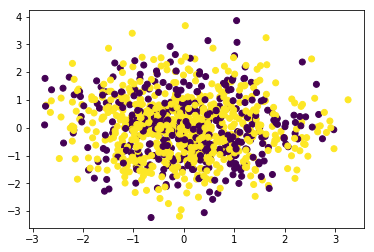

In [138]:
x = mu_latent[:, 0].data.cpu().numpy()
y = mu_latent[:, 1].data.cpu().numpy()

x_std = list(np.round(np.exp(logvar_latent[:, 0].mul(0.5).exp().data.cpu().numpy()), 2)**2)
y_std = list(np.round(np.exp(logvar_latent[:, 1].mul(0.5).exp().data.cpu().numpy()), 2)**2)

plt.scatter(x, y, c=dataset.assignment_data)
# plt.errorbar(x[:10], y[:10], yerr=y_std[:10], xerr=x_std[:10])
plt.show()


### Process Datasets

As above, this code trains a VAE for persisted datasets and saves the encoded data to disk. 

In [ ]:
assignment_model_names = ['A_add_lin', 'B_add_mild_nlin', 'C_add_mod_nlin', 'D_mild_nadd_lin',
                     'E_mild_nadd_mild_nlin', 'F_mod_nadd_lin', 'G_mod_nadd_mod_nlin']

for dataset_number in range(0, 200):
    print("Starting run for Dataset {}".format(dataset_number))
    
    for model_name in assignment_model_names:
        print("-- Running for model name: ", model_name)
        
        start = time()

        dataset = CovariateDataset("n_{}_model_{}_v_{}_covar_data", [1000, model_name, dataset_number])

        trained_model, original_data, binary_mu_out, normal_mu_out, mu_latent, logvar_latent = \
            train_model(ModifiedVAE, dataset, dataset_number,verbose=True)

        encode_data(trained_model, dataset)

        print("---- Done in ", time() - start, " seconds\n")
                
    print("================\n\n")

In [ ]:
models_to_rerun = [('A_add_lin', 12, 'sparsity'), ('G_mod_nadd_mod_nlin', 40, 'sparsity')]

for model_name, dataset_number, loss_type in models_to_rerun:
    dataset = CovariateDataset("n_{}_model_{}_v_{}_covar_data", [1000, model_name, dataset_number])
    trained_model, final_loss = train_model(
                                        autoencoder,
                                        dataset,
                                        loss=loss_type,
                                        verbose=True)
    encode_data(trained_model, dataset, loss=loss_type)